In [24]:
import os 
import numpy as np
import pandas as pd
import numpy as np

from classes.matlab_reader import matlab_reader
from classes.grid_funcs import map_grid,dataset,data_wizard
from dotenv import load_dotenv   #for python-dotenv method
from datetime import datetime

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)


In [25]:
# Get Temperature Data]
def generate_dataset(path='/Users/joaojesus/Desktop/final_year_proj/PROCESSED_ERA5_ONLINE/COMPRESSED/WIND_EASTWARD/',
                    geo_filtering = {'min_lat':60,'max_lat':80,'min_lon':-180, 'max_lon': 180},
                    year_selection = '1995',
                    data_name = 'wind_eastward'):
    
    grid = map_grid(grid_size=None, source = 'era5')
    wizard = data_wizard()
    res_mean = []
    res_mean_selection = []
    file_names = []
    files = os.listdir(path)
    files.sort()
    for file in files:
        if file[:4] == year_selection:
            temperature = np.load(path + file)['arr_0']

            select_area_indexer = grid.select_area_indexer(
                min_lat= geo_filtering['min_lat'],
                max_lat= geo_filtering['max_lat'],
                min_lon= geo_filtering['min_lon'],
                max_lon= geo_filtering['max_lat'])

            data = wizard.data_filtering(select_area_indexer = select_area_indexer ,data = temperature)

            file_names.append(file[:10])
            res_mean.append(np.nanmean(temperature))
            res_mean_selection.append(np.nanmean(data))

    df = pd.DataFrame(data={
        'dates' : file_names,
        f'{data_name}_mean' : res_mean,
        f'{data_name}_mean_selection' : res_mean_selection
    })
    
    df['dates'] = pd.to_datetime(df['dates'])
    df = df.sort_values(by='dates')
    df = df.reset_index()
    df = df.drop(columns=['index'])

    return df

def find_ssw(df):
    values = df['wind_eastward_mean_cos'].to_list()
    SSW_ = [False]

    for i in range(1,len(values)):
        if values[i-1] >= 0 and values[i] < 0:
            SSW_.append(True)
        else:
            SSW_.append(False)

    df['SSW_'] = SSW_
    df['SSW_flag'] = False

    day_threshold = 1
    for index in df[df['SSW_'] == True].index:
        if len(df.iloc[index:index+day_threshold].loc[df['wind_eastward_mean_cos'] < 0]) >= day_threshold :
            df['SSW_flag'].iloc[index] = True
    return df
    

In [27]:
flag = True
if flag:
        
    df_all  = pd.DataFrame()
    for year in range(2002,2019+1):
        YEAR = year

        df_wind = generate_dataset(path='/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/',
                            geo_filtering = {'min_lat':59,'max_lat':61,'min_lon':-180, 'max_lon': 180},
                            year_selection = f'{YEAR}',
                            data_name = 'wind_eastward')

        df_temperature = generate_dataset(path='/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/TEMPERATURE/',
                            geo_filtering = {'min_lat':60,'max_lat':90,'min_lon':-180, 'max_lon': 180},
                            year_selection = f'{YEAR}',
                            data_name = 'temperature')

        df = pd.merge(df_wind,df_temperature[['dates','temperature_mean_selection']],how='left', on='dates')
        
        df['wind_eastward_mean_cos'] = df['wind_eastward_mean'] * np.cos(np.deg2rad(60))
        df = find_ssw(df)

        index = df.index[df['SSW_flag'] == True].tolist()
        
        df_all = pd.concat([df_all,df])

In [28]:
# save all

df = df_all
df = df.reset_index()
df = df.drop(columns = ['index'])
index = df.index[df['SSW_flag'] == True].tolist()

SAVE_SSW_EVENT = False
if SAVE_SSW_EVENT:
    if len(index) > 0:
        for index in index:
            try: 

                day_window = 45
                df_dataset = df.loc[index-day_window:index+day_window]
                df_dataset['t_delta'] = [i for i in range(-day_window,day_window+1)]
                date_str = df.loc[index]['dates'].strftime("%Y-%m-%d")
                df_dataset = df_dataset.reset_index()
                df_dataset= df_dataset.drop(columns=['index'])
                df_dataset = df_dataset.drop(columns=['SSW_'])
                
                df_dataset.to_csv(f'ssw_events_saved/{date_str}_ssw.csv', sep=',',index=False)
            except:
                print('error')
                pass



In [5]:
import plotly.graph_objects as go

# Create figure and plot the DataFrame
fig = go.Figure()

fig.add_trace(go.Scatter(x=df['dates'], y=df['wind_eastward_mean_cos'], name='ZMZW', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df['dates'], y=df['temperature_mean_selection'], name='Mean Temperature', line=dict(color='orange'), yaxis='y2'))


# Add a dashed line at y=0
fig.add_shape(type='line', x0=df['dates'].min(), y0=0, x1=df['dates'].max(), y1=0, line=dict(color='gray', dash='dash'))

# Find the index of the first negative value
first_negative_index = (df['wind_eastward_mean_cos'] < 0).idxmin()

# Add vertical lines for SSW_flag == True
for i, row in df.iterrows():
    if row.SSW_flag == True:
        fig.add_shape(type='line', x0=row.dates, y0=-50, x1=row.dates, y1=50, line=dict(color='red', dash='dash'))

# Set layout
fig.update_layout(
    yaxis=dict(
        range=[-50, 80],
        title='ZMZW at 60◦ N latitude (m/s)'
    )
    ,yaxis2=dict(
        range=[190, 250],
        title='Zonal Temperature at 60◦ N to 90◦ N (k)',
        side='right',
        overlaying='y'
    )
    ,xaxis=dict(title='Dates'),
    # title=f'ZMZW at 60◦ N latitude in {YEAR}',
    title=f'SSW Event between 2018 and 2019',
    legend=dict(orientation="h", y=1.2, x=0.5),
    # Set the background color to white
    plot_bgcolor='white',
    # Set the grid color to grey
    xaxis_gridcolor='lightgray',
    yaxis_gridcolor='lightgray'
)

# Show the plot
fig.show()


In [6]:
# load era5 data

grid = map_grid(grid_size=None, source = 'era5_online')
wizard = data_wizard()

data_u = np.load('/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/2002-03-16.npz')['arr_0']
data_v= np.load('/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_NORTHWARD/2002-03-16.npz')['arr_0']


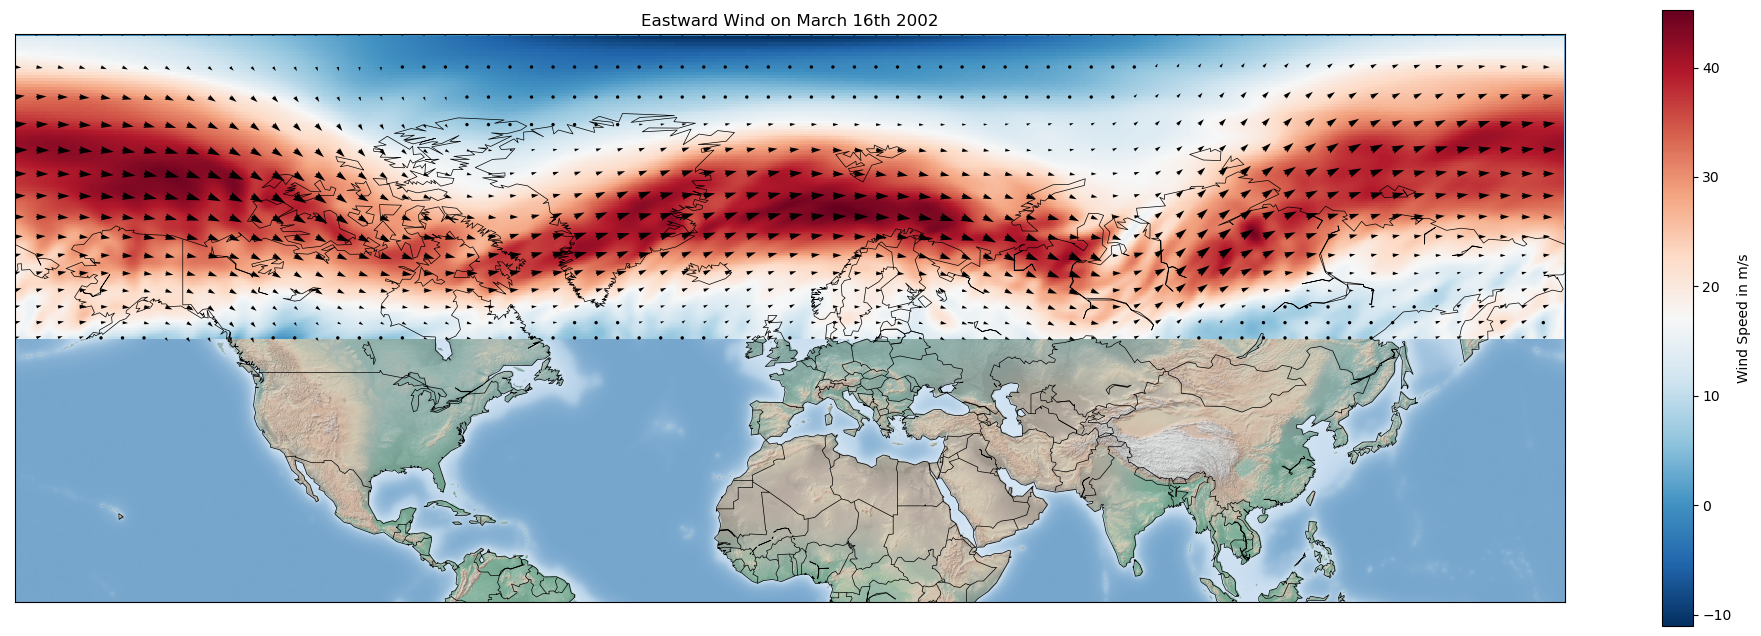

In [7]:
# =============================================
# plot a single day on a colour mesh and quiver
# =============================================

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(25, 8))

# use to plot north pole stero plot
# plot sterographic projection
# m = Basemap(projection='npstere',boundinglat=0,lon_0=0,resolution='c')

# plot miller projection
m = Basemap(projection='mill',
            llcrnrlat = 0,
            urcrnrlat = 90,
            llcrnrlon = -180,
            urcrnrlon =180)

m.shadedrelief(scale=0.5)

m.pcolormesh(grid.grid_[0], 
             grid.grid_[1], 
             data_u,
             latlon=True, cmap='RdBu_r',
             shading='auto')

x = grid.grid_[0][::10, ::20]
y = grid.grid_[1][::10, ::20]

data_u_d = data_u[::10, ::20]
data_v_d = data_v[::10, ::20]


m.quiver(x, y, 
     data_u_d, data_v_d,scale = 5000,latlon=True)


m.drawcoastlines(linewidth=0.5,linestyle='solid')
m.drawcountries(linewidth=0.5, linestyle='solid',color='k')

# change density of arrows

# plt.title('Eastward Wind on March 16th 2002')
plt.title('Eastward Wind on March 16th 2002')
plt.colorbar(label='Wind Speed in m/s')

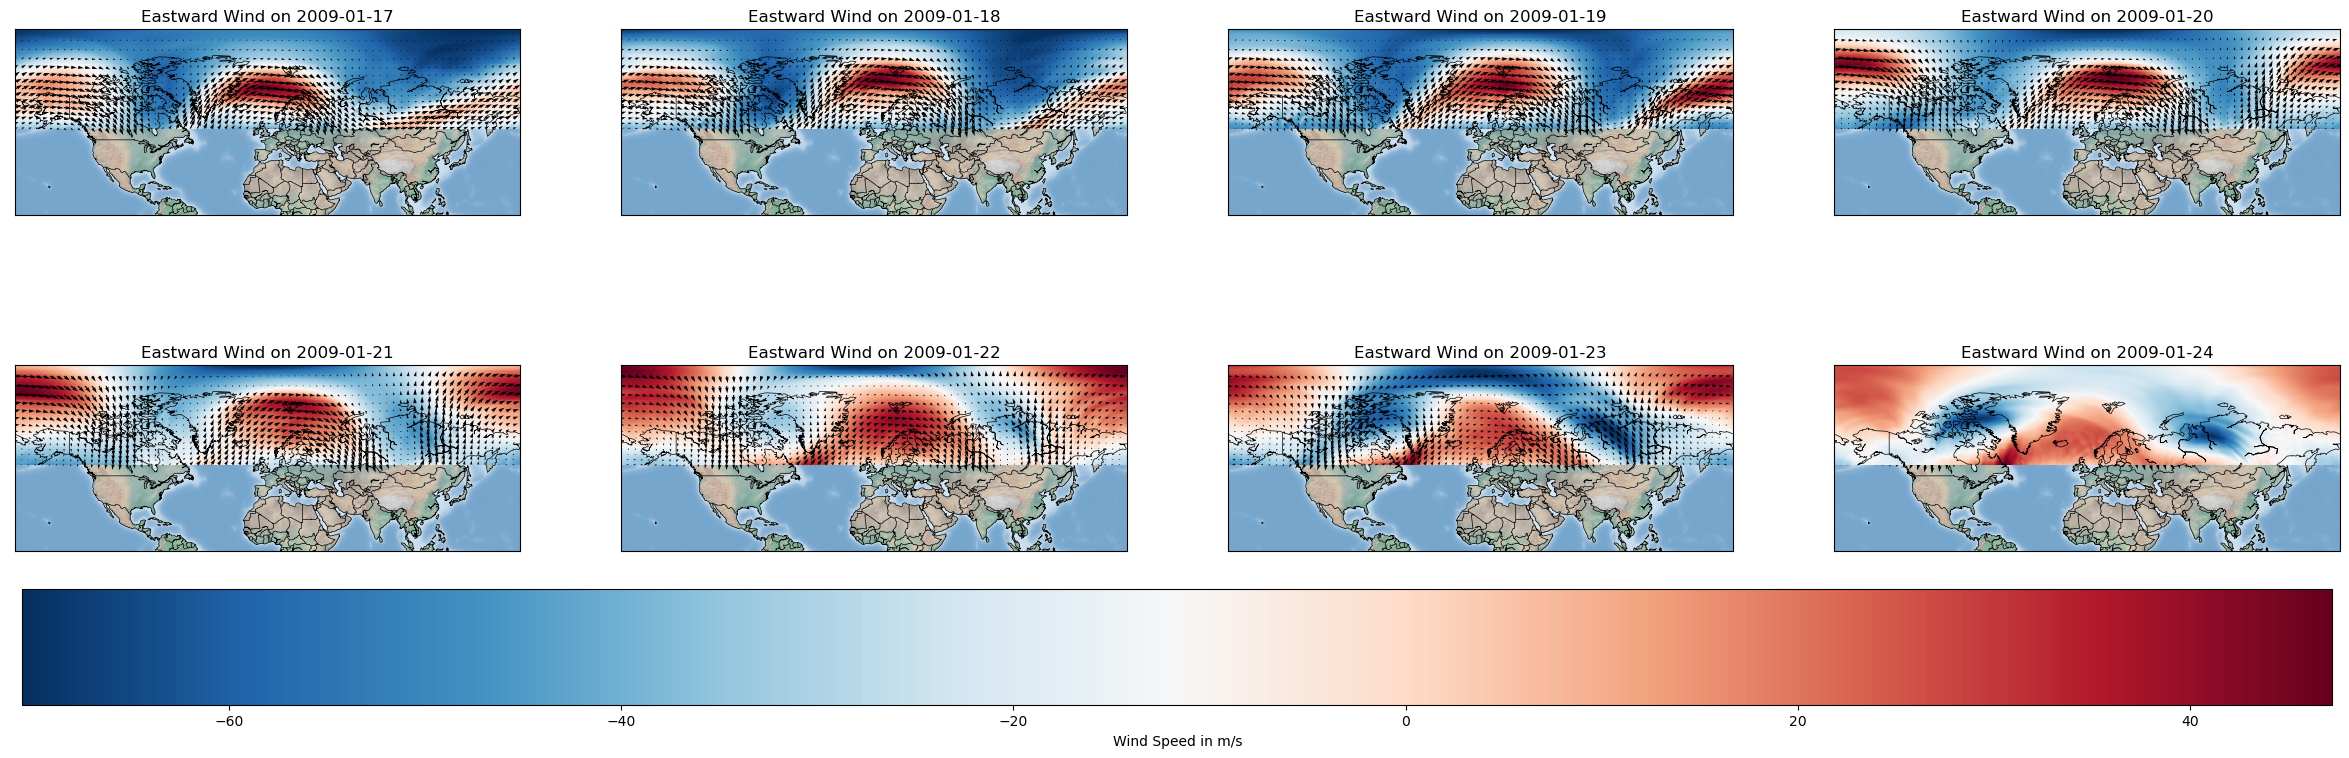

In [8]:
# =============================================
# plot a multiple days on a colour mesh and quiver
# =============================================

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

dates = ["2009-01-17","2009-01-18","2009-01-19","2009-01-20","2009-01-21","2009-01-22","2009-01-23","2009-01-24"]


data_u_1 = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/{dates[0]}.npz')['arr_0']
data_v_1 = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_NORTHWARD/{dates[0]}.npz')['arr_0']

data_u_2 = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/{dates[1]}.npz')['arr_0']
data_v_2 = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_NORTHWARD/{dates[1]}.npz')['arr_0']

data_u_3 = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/{dates[2]}.npz')['arr_0']
data_v_3 = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_NORTHWARD/{dates[2]}.npz')['arr_0']

data_u_4  = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/{dates[3]}.npz')['arr_0']
data_v_4 = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_NORTHWARD/{dates[3]}.npz')['arr_0']

data_u_5  = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/{dates[4]}.npz')['arr_0']
data_v_5 = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_NORTHWARD/{dates[4]}.npz')['arr_0']

data_u_6  = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/{dates[5]}.npz')['arr_0']
data_v_6 = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_NORTHWARD/{dates[5]}.npz')['arr_0']

data_u_7  = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/{dates[6]}.npz')['arr_0']
data_v_7 = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_NORTHWARD/{dates[6]}.npz')['arr_0']

data_u_8  = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/{dates[7]}.npz')['arr_0']
data_v_8 = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_NORTHWARD/{dates[7]}.npz')['arr_0']


data_dict = {'data_u_1': data_u_1,
            'data_u_2': data_u_2,
            'data_u_3': data_u_3,
            'data_u_4': data_u_4,
            'data_u_5': data_u_5,
            'data_u_6': data_u_6,
            'data_u_7': data_u_7,
            'data_u_8': data_u_8,
            'data_v_1': data_v_1,
            'data_v_2': data_v_2,
            'data_v_3': data_v_3,
            'data_v_4': data_v_4,
            'data_v_5': data_v_5,
            'data_v_6': data_v_6,
            'data_v_7': data_v_7,
            'data_v_8': data_v_8}


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 10))

data_i = 1

for i in range(2):
    for j in range(4):

        data_u = data_dict[f'data_u_{data_i}']
        data_v = data_dict[f'data_v_{data_i}']

        ax = axes[i, j]

        m = Basemap(projection='mill',
                    llcrnrlat = 0,
                    urcrnrlat = 90,
                    llcrnrlon = -180,
                    urcrnrlon =180,
                    ax=ax)

        m.shadedrelief(scale=0.5)

        m.pcolormesh(grid.grid_[0], 
                     grid.grid_[1], 
                     data_u,
                     latlon=True, cmap='RdBu_r',
                     shading='auto')

        x = grid.grid_[0][::10, ::20]
        y = grid.grid_[1][::10, ::20]

        data_u_d = data_u[::10, ::20]
        data_v_d = data_v[::10, ::20]

        m.quiver(x, y, 
             data_u_d, data_v_d,scale = 5000,latlon=True)

        m.drawcoastlines(linewidth=0.5,linestyle='solid')
        m.drawcountries(linewidth=0.5, linestyle='solid',color='k')

        # Set the title of the subplot
        ax.set_title('Eastward Wind on ' + dates[data_i-1])

        # increment the data_i
        data_i += 1

# Define the mappable object for the colorbar
mappable = m.pcolormesh(grid.grid_[0], 
                         grid.grid_[1], 
                         data_u,
                         latlon=True, cmap='RdBu_r',
                         shading='auto')

# Add the colorbar at the bottom of the figure
fig.colorbar(mappable, ax=axes, location='bottom', pad=0.05, label='Wind Speed in m/s')

plt.show()


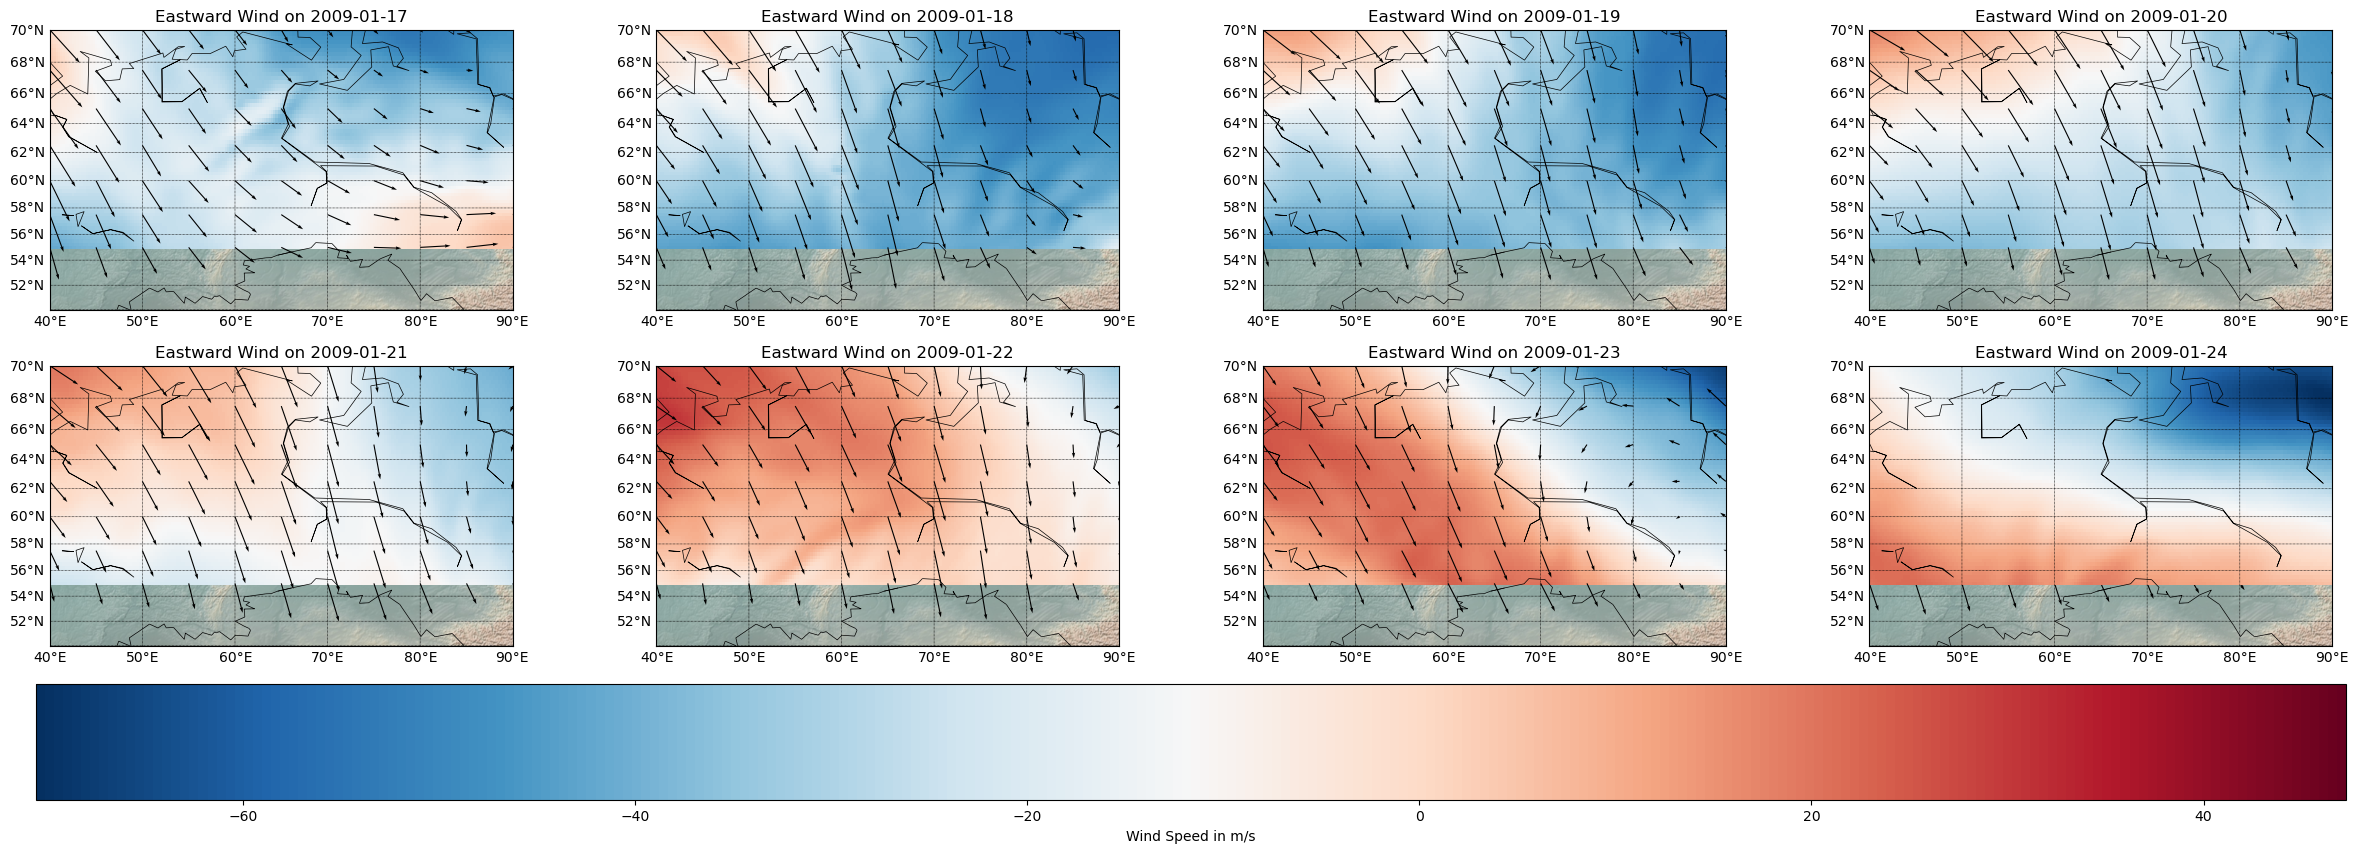

In [23]:
# =============================================
# plot a multiple days on a colour mesh and quiver
# =============================================
# load era5 data

grid = map_grid(grid_size=None, source = 'era5_online')
wizard = data_wizard()

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

dates = ["2009-01-17","2009-01-18","2009-01-19","2009-01-20","2009-01-21","2009-01-22","2009-01-23","2009-01-24"]


data_u_1 = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/{dates[0]}.npz')['arr_0']
data_v_1 = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_NORTHWARD/{dates[0]}.npz')['arr_0']

data_u_2 = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/{dates[1]}.npz')['arr_0']
data_v_2 = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_NORTHWARD/{dates[1]}.npz')['arr_0']

data_u_3 = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/{dates[2]}.npz')['arr_0']
data_v_3 = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_NORTHWARD/{dates[2]}.npz')['arr_0']

data_u_4  = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/{dates[3]}.npz')['arr_0']
data_v_4 = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_NORTHWARD/{dates[3]}.npz')['arr_0']

data_u_5  = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/{dates[4]}.npz')['arr_0']
data_v_5 = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_NORTHWARD/{dates[4]}.npz')['arr_0']

data_u_6  = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/{dates[5]}.npz')['arr_0']
data_v_6 = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_NORTHWARD/{dates[5]}.npz')['arr_0']

data_u_7  = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/{dates[6]}.npz')['arr_0']
data_v_7 = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_NORTHWARD/{dates[6]}.npz')['arr_0']

data_u_8  = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/{dates[7]}.npz')['arr_0']
data_v_8 = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_NORTHWARD/{dates[7]}.npz')['arr_0']


data_dict = {'data_u_1': data_u_1,
            'data_u_2': data_u_2,
            'data_u_3': data_u_3,
            'data_u_4': data_u_4,
            'data_u_5': data_u_5,
            'data_u_6': data_u_6,
            'data_u_7': data_u_7,
            'data_u_8': data_u_8,
            'data_v_1': data_v_1,
            'data_v_2': data_v_2,
            'data_v_3': data_v_3,
            'data_v_4': data_v_4,
            'data_v_5': data_v_5,
            'data_v_6': data_v_6,
            'data_v_7': data_v_7,
            'data_v_8': data_v_8}


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 10))

data_i = 1

for i in range(2):
    for j in range(4):

        data_u = data_dict[f'data_u_{data_i}']
        data_v = data_dict[f'data_v_{data_i}']

        ax = axes[i, j]

        # m = Basemap(projection='stere',
        #             lon_0 = 60,
        #             lat_0 = 60,
        #             llcrnrlat = 50,
        #             urcrnrlat = 70,
        #             llcrnrlon = 40,
        #             urcrnrlon = 90,
        #             ax=ax)

        m = Basemap(projection='mill',

                    llcrnrlat = 50,
                    urcrnrlat = 70,
                    llcrnrlon = 40,
                    urcrnrlon = 90,
                    ax=ax)

        m.shadedrelief(scale=0.5)

        m.pcolormesh(grid.grid_[0], 
                     grid.grid_[1], 
                     data_u,
                     latlon=True, cmap='RdBu_r',
                     shading='auto')

        x = grid.grid_[0][::10, ::20]
        y = grid.grid_[1][::10, ::20]

        data_u_d = data_u[::10, ::20]
        data_v_d = data_v[::10, ::20]

        m.quiver(x, y, 
             data_u_d, data_v_d,scale = 1000,latlon=True)

        m.drawcoastlines(linewidth=0.5,linestyle='solid')
        m.drawcountries(linewidth=0.5, linestyle='solid',color='k')
        m.drawparallels(np.arange(50, 71, 2), linewidth=0.5, labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(40, 91, 10), linewidth=0.5, labels=[0, 0, 0, 1])

        # Set the title of the subplot
        ax.set_title('Eastward Wind on ' + dates[data_i-1])

        # increment the data_i
        data_i += 1

# Define the mappable object for the colorbar
mappable = m.pcolormesh(grid.grid_[0], 
                         grid.grid_[1], 
                         data_u,
                         latlon=True, cmap='RdBu_r',
                         shading='auto')

# Add the colorbar at the bottom of the figure
fig.colorbar(mappable, ax=axes, location='bottom', pad=0.05, label='Wind Speed in m/s')

plt.show()
